# <center> Analysez les ventes d'une librairie avec Python </center>

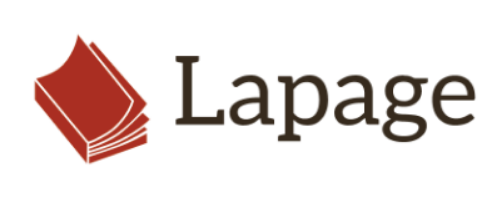

# <center> Observations et Tests statistiques </center>

### Sommaire:

* [Importation des librairies et des données](#chapter0)

* [I) Rappel](#chapter1)
    
* [II) Demandes d'Antoine](#chapter2)
    * [1) Indicateur autour du chiffre d'affaires](#section_2_1)
    * [2) Zoom sur les références](#section_2_2)
    * [3) Profils des clients](#section_2_3)
    
* [III) Demandes de Julie](#chapter3)
    * [1) Déclaration des fonctions](#section_5_1)
    * [2) Lien entre Genre d'un client et Catégorie des livres achetés](#section_3_2)
    * [3) Lien entre Age des clients et Montant total des achats](#section_3_3)
    * [4) Lien entre Age des clients et Fréquence d'achat](#section_3_4)
    * [5) Lien entre Age des clients et Taille du panier moyen](#section_3_5)
    * [6) Lien entre Age des clients et Catégorie des livres achetés](#section_3_6)
    * [7) Conclusion](#section_3_7)

##  Importation des librairies et des données <a class="anchor" id="chapter0"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as scipy
from scipy import stats
import math

In [2]:
data = pd.read_csv('Lapage_data.csv')

## I) Rappel <a class="anchor" id="chapter1"></a>

LAPAGE a ouvert sa librairie en ligne il y a deux ans et désire à présent faire un point afin de décider des prochaines marches à suivre. Par exemple, décider si il faut créer certaines offres, adapter certains prix, etc.

Après avoir étudié et préparé nos données, nous avons obtenu un fichier, appelé "data", rassemblant toutes les informations que nous avions à disposition.

Dans la suite du notebook nous allons ainsi réaliser différentes observations et tests afin de répondre aux demandes d'Antoine et Julie.

***

Avant tout nous allons ajouter à notre jeu de données quelques informations qui seront utiles pour nos analyses:

In [3]:
#ajout de "date_simple" une variable qui reprend la date de manière simplifiée (précision au jour):
data["date_simple"] = data["année"].map(str) + '-' + data["mois"].map(str) + '-' + data["jour"].map(str)
data["date_simple"] = pd.to_datetime(data["date_simple"])

#ajout de "nom_jour" qui indique le jour de la semaine correspond à la date de la transaction:
data["nom_jour"] = data['date_simple'].dt.day_name()

#ajout de "ventes" indiquant simplement que chaque ligne correspond à une vente, afin de les comptabiliser par la suite:
data["ventes"] = 1

data.head()

,id_prod,date,session_id,client_id,genre,année de naissance,prix,catégorie,âge,année,mois,jour,heure,date_simple,nom_jour,ventes
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,f,1986,4.18,0,37,2022,5,20,13,2022-05-20,Friday,1
1,0_1518,2021-07-20 13:21:29.043970,s_64849,c_103,f,1986,4.18,0,37,2021,7,20,13,2021-07-20,Tuesday,1
2,0_1518,2022-08-20 13:21:29.043970,s_255965,c_103,f,1986,4.18,0,37,2022,8,20,13,2022-08-20,Saturday,1
3,0_1518,2021-05-09 11:52:55.100386,s_32104,c_6714,f,1968,4.18,0,55,2021,5,9,11,2021-05-09,Sunday,1
4,0_1518,2022-05-30 01:17:07.487046,s_216118,c_6714,f,1968,4.18,0,55,2022,5,30,1,2022-05-30,Monday,1


## II ) Demandes d'Antoine: <a class="anchor" id="chapter2"></a>

Dans un premier temps, différents indicateurs et graphiques autour du chiffre d'affaires ainsi que l’évolution dans le temps et une décomposition en moyenne mobile pour évaluer la tendance globale.

Un zoom sur les références, pour voir un peu les tops et les flops, la répartition par catégorie, etc.

Quelques informations sur les profils de nos clients, la répartition du chiffre d'affaires entre eux, via par exemple une courbe de Lorenz.

### 1) Indicateurs autour du chiffres d'affaires <a class="anchor" id="section_2_1"></a>

##### Chiffre d'affaires global:

In [4]:
print(data['prix'].sum())

11856080.12


##### Chiffre d'affaires moyen par client:

In [5]:
data_cl = data.groupby(["client_id", "âge", "genre"])["prix"].sum().reset_index()
print(data_cl["prix"].mean())

1378.61396744186


##### Évolution dans le temps:

3.2645231053136192


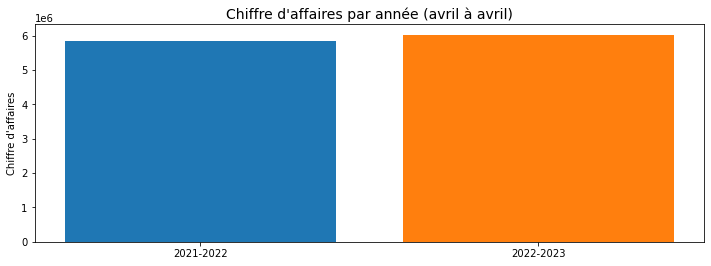

In [6]:
data_2122 = data.loc[data["date_simple"] < "2022-03-01"] # données 21-22, soit avant le 1er mars 2022
data_2223 = data.loc[data["date_simple"] >= "2022-03-01"] # données 22-23, soit à partir du 1er mars 2022

plt.figure(figsize=(12, 4))
plt.title("Chiffre d'affaires par année (avril à avril)", size=14)

plt.bar(x=["2021-2022"], height=data_2122["prix"].sum())
plt.bar(x=["2022-2023"], height=data_2223["prix"].sum())

plt.ylabel("Chiffre d'affaires", size=10)

print(((data_2223["prix"].sum()-data_2122["prix"].sum())/data_2122["prix"].sum()*100))

In [65]:
data_2223["prix"].sum()

6023247.150000001

On constate une légère augmentation du chiffre d'affaire entre les années 2021-2022 et 2022-2023 (+3.3%)



Regardons plus en détails comment ce chiffre d'affaires a fluctué au cours des 2 dernières années:

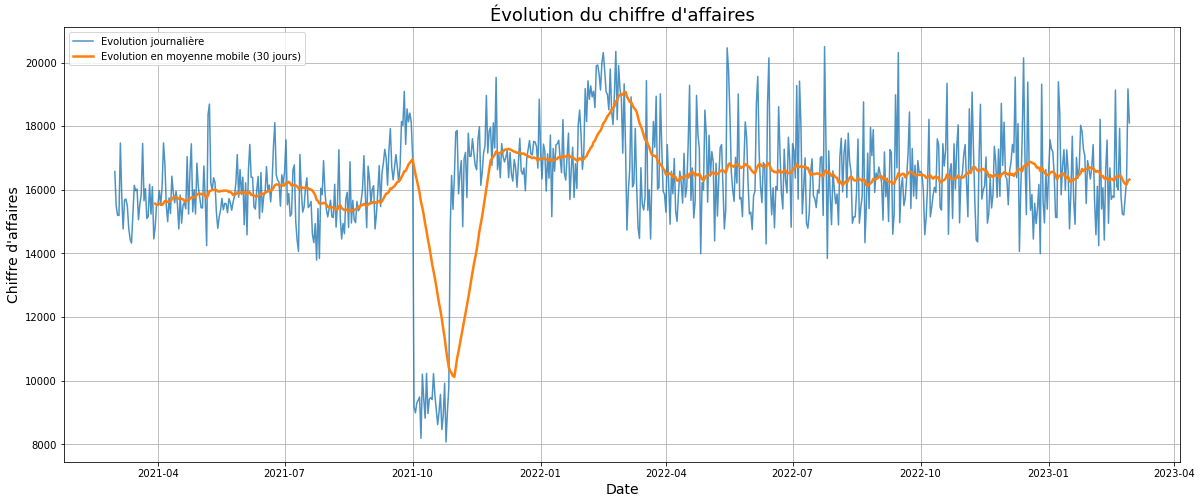

In [7]:
data_day = data.groupby(["date_simple", "nom_jour"])["prix"].sum().reset_index()
data_day["moy_mob_1m"] = data_day["prix"].rolling(30).mean() #ajout d'une variable moyenne mobile sur 30 jours

x=data_day["date_simple"]
y=data_day["prix"]
y2=data_day["moy_mob_1m"]

plt.figure(figsize=(20, 8))
plt.title("Évolution du chiffre d'affaires", size=18)

plt.plot(x, y, alpha=0.8, label="Evolution journalière")
plt.plot(x, y2, linewidth=2.5, label="Evolution en moyenne mobile (30 jours)")

plt.xlabel("Date", size=14)
plt.ylabel("Chiffre d'affaires", size=14)

plt.grid(True)
plt.legend()

plt.show()

Grâce à la moyenne mobile on constate que le chiffres d'affaires est en effet plus élevé à partir de 2022. 

Mais surtout, celui-ci reste globalement constant sur les 12 derniers mois, ce qui est une bonne chose après avoir connu deux périodes "anormales":
- une chute importante en octobre 2021
- une brève augmentation autour de février 2022

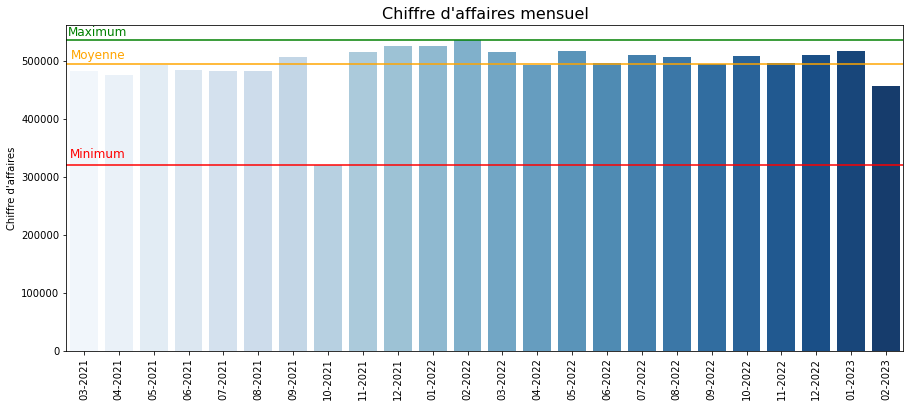

In [8]:
data["mois_an"] = data["mois"].map(str) + '-' + data["année"].map(str) # création d'une variable identifiant les mois
data["mois_an"] = pd.to_datetime(data["mois_an"])
data_month = data.groupby(["mois_an"])["prix"].sum().reset_index()

plt.figure(figsize=(15, 6))
plt.title("Chiffre d'affaires mensuel", size = 16)

sns.barplot(data=data_month, x="mois_an", y="prix", 
            estimator=sum, 
            ci=None,
            palette="Blues")

plt.ylabel("Chiffre d'affaires", size = 10)
plt.xlabel("", size = 12)
plt.xticks(np.arange(0, 24, step=1), ["03-2021", "04-2021", "05-2021", "06-2021", "07-2021", "08-2021", "09-2021", "10-2021", "11-2021", "12-2021", 
            "01-2022", "02-2022", "03-2022", "04-2022", "05-2022", "06-2022", "07-2022", "08-2022", "09-2022", "10-2022", 
            "11-2022", "12-2022", "01-2023", "02-2023"], rotation=90)
plt.axhline(y=data_month["prix"].mean(), color='orange', linestyle='-')
plt.axhline(y=data_month["prix"].min(), color='red', linestyle='-')
plt.axhline(y=data_month["prix"].max(), color='green', linestyle='-')
plt.text(0.4, 510000, "Moyenne", fontsize=12, color="orange", horizontalalignment='center', verticalalignment='center')
plt.text(0.4, 340000, "Minimum", fontsize=12, color="red", horizontalalignment='center', verticalalignment='center')
plt.text(0.4, 550000, "Maximum", fontsize=12, color="green", horizontalalignment='center', verticalalignment='center')

plt.show()

On distingue aisément le mois d'octobre 2021, dont les ventes sont très inférieures au autres mois, mais aussi le mois de février 2022 qui à l'inverse représente le plus gros chiffre d'affaires mensuel de ces 2 dernières années. 

Essayons de voir plus en détails, notamment à travers nos différentes catégories, si nous trouvons une explication à ces 2 pics.

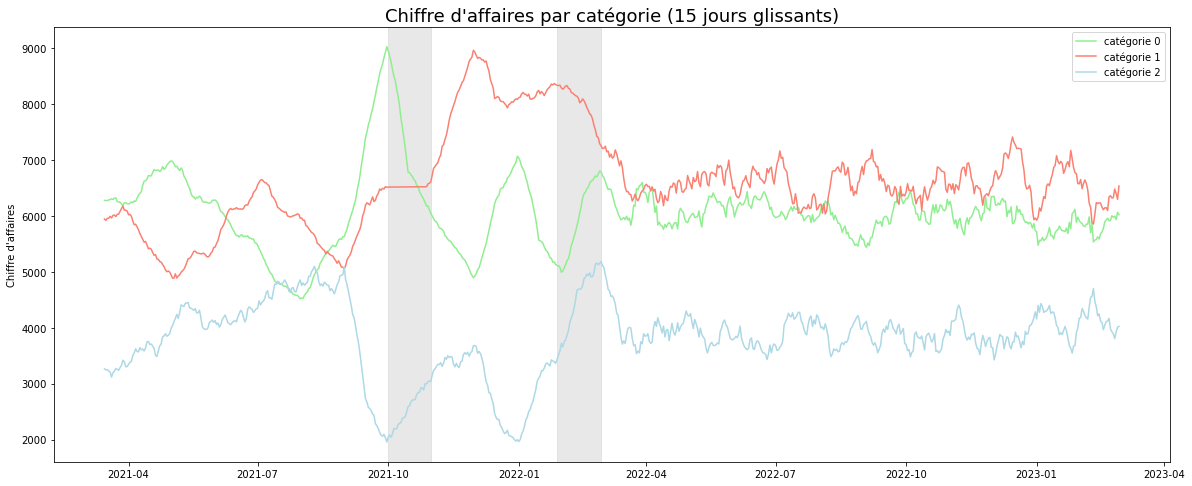

In [9]:
# on isole nos données selon la catégorie du produit
cat_0 = data.loc[data["catégorie"] == 0]
cat_1 = data.loc[data["catégorie"] == 1]
cat_2 = data.loc[data["catégorie"] == 2]

#classement par date des ventes de la catégorie 0:
evo_cat0 = cat_0.groupby("date_simple").sum().reset_index().sort_values("date_simple")
evo_cat0["moyenne_mobile_2s"] = evo_cat0["prix"].rolling(15).mean()

#classement par date des ventes de la catégorie 1:
evo_cat1 = cat_1.groupby("date_simple").sum().reset_index().sort_values("date_simple")
evo_cat1["moyenne_mobile_2s"] = evo_cat1["prix"].rolling(15).mean()

#classement par date des ventes de la catégorie 2:
evo_cat2 = cat_2.groupby("date_simple").sum().reset_index().sort_values("date_simple")
evo_cat2["moyenne_mobile_2s"] = evo_cat2["prix"].rolling(15).mean()


plt.figure(figsize=(20, 8))
plt.title("Chiffre d'affaires par catégorie (15 jours glissants)", size = 18)

x0=evo_cat0["date_simple"]
x1=evo_cat1["date_simple"]
x2=evo_cat2["date_simple"]
y0=(evo_cat0["moyenne_mobile_2s"])
y1=(evo_cat1["moyenne_mobile_2s"])
y2=(evo_cat2["moyenne_mobile_2s"])

plt.plot(x0, y0, color="lightgreen", label="catégorie 0")
plt.plot(x1, y1, color="salmon", label="catégorie 1")
plt.plot(x2, y2, color="lightblue", label="catégorie 2")

plt.legend()
plt.ylabel("Chiffre d'affaires", size = 10)
plt.xlabel("", size = 14)
plt.axvspan("2021-10-01", "2021-10-31", color="lightgray", alpha=0.5)
plt.axvspan("2022-01-28", "2022-02-28", color="lightgray", alpha=0.5)

plt.show()

On comprend ici que le ralentissement observé au mois d'octobre 2021 est principalement dû à une chute des ventes des produits de la catégorie 0, qui était à l'époque la catégorie leader de notre activité, non compensée par la légère progression de la catégorie 2.

Au mois de février 2022 la hausse du chiffre d'affaires global peut s'expliquer par des pics de ventes quasi-identiques des catégorie 0 et 2, malgrè une légère baisse de la catégorie 1.

##### Chiffre d'affaires par jour de la semaine

(0.0, 2000000.0)

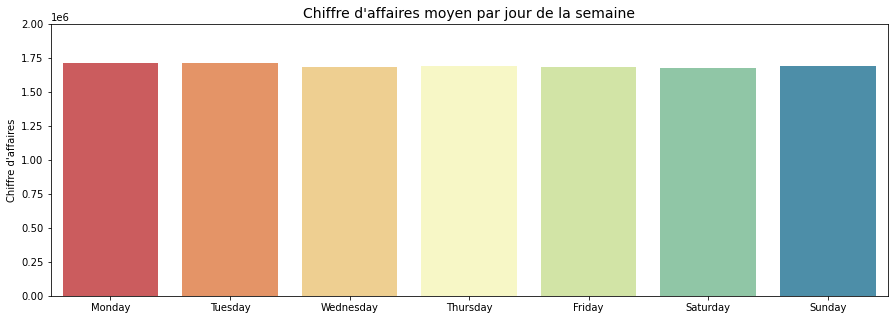

In [10]:
data["nom_jour"] = data['date_simple'].dt.day_name()

plt.figure(figsize=(15, 5))
plt.title("Chiffre d'affaires moyen par jour de la semaine", size=14)

sns.barplot(data=data, x="nom_jour", y="prix", 
            estimator=sum, 
            ci=None,
            order=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday",],
            palette="Spectral")

plt.ylabel("Chiffre d'affaires", size = 10)
plt.xlabel("", size = 14)
plt.ylim(0, 2000000)

##### Chiffre d'affaires par heure de la journée

(0.0, 750000.0)

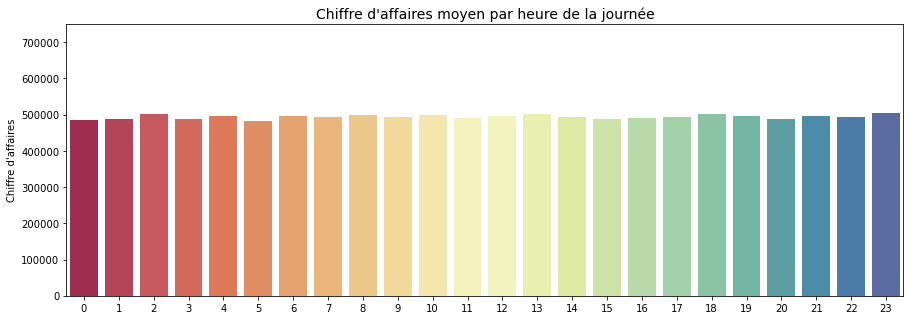

In [11]:
plt.figure(figsize=(15, 5))
plt.title("Chiffre d'affaires moyen par heure de la journée", size=14)

sns.barplot(data=data, x="heure", y="prix", 
            estimator=sum, 
            ci=None,
            palette="Spectral")

plt.ylabel("Chiffre d'affaires", size = 10)
plt.xlabel("", size = 14)
plt.ylim(0, 750000)

Que ce soit par mois, par jour ou par heure nous n'observons pas une périodicité importante du chiffre d'affaires.

### 2) Zoom sur les références <a class="anchor" id="section_2_2"></a>

##### Part du chiffre d'affaires par catégorie:

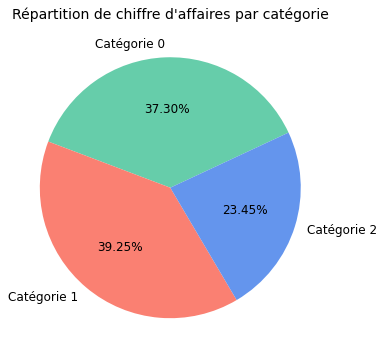

In [12]:
plt.figure(figsize=(6, 6))
plt.title("Répartition de chiffre d'affaires par catégorie", size=14)

labels = 'Catégorie 0', 'Catégorie 1', 'Catégorie 2'
sizes = [cat_0["prix"].sum(), cat_1["prix"].sum(), cat_2["prix"].sum()]
colors = 'mediumaquamarine', 'salmon', 'cornflowerblue'
explode = (0.1, 0.1, 0.1)

plt.pie(sizes, 
        labels=labels, 
        colors = colors,
        autopct='%1.2f%%',
        shadow=False, 
        startangle=25, 
        textprops={'size':12})

plt.show()

##### Prix moyen par catégorie:

Text(0.5, 0, 'Catégorie')

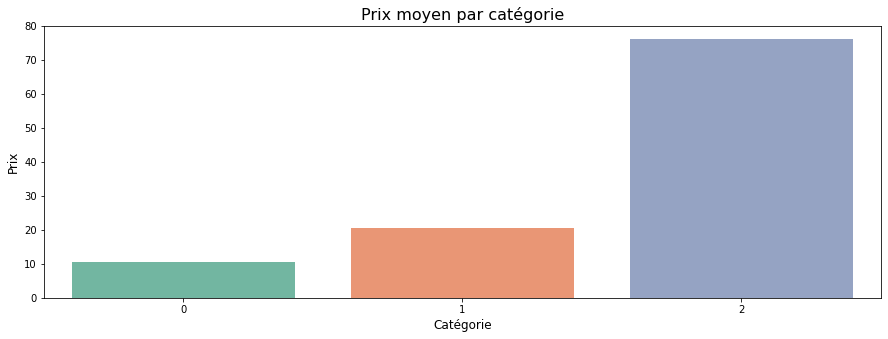

In [13]:
plt.figure(figsize=(15,5))
plt.title("Prix moyen par catégorie", size=16)

sns.barplot(x="catégorie", y="prix",
            data=data,
            ci=None,
            palette="Set2")

plt.ylabel("Prix", size = 12)
plt.xlabel("Catégorie", size = 12)

##### Distribution des prix par catégorie:

Text(0.5, 0, 'Catégorie')

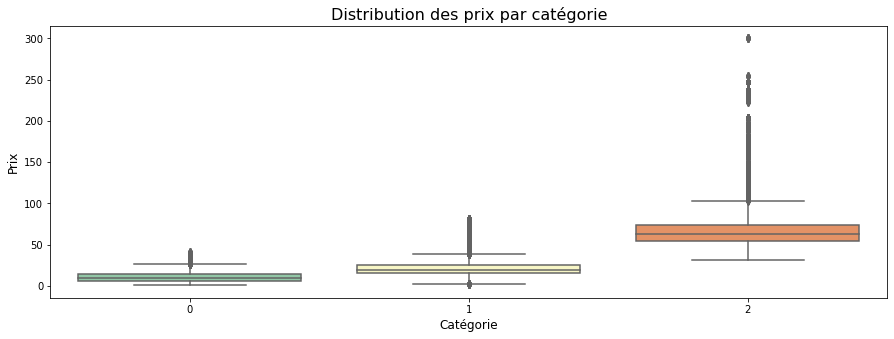

In [14]:
plt.figure(figsize=(15,5))
plt.title("Distribution des prix par catégorie", size=16)

sns.boxplot(y="prix", x="catégorie", data=data, orient="v", palette="Spectral_r" )

plt.ylabel("Prix", size = 12)
plt.xlabel("Catégorie", size = 12)

###### Top & Flop - Global

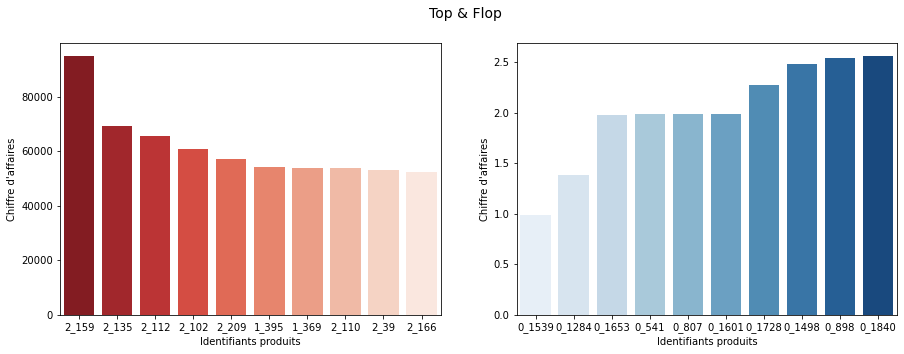

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.suptitle("Top & Flop", size=14)

bar_top = sns.barplot(x="id_prod", y="prix",
            data=data.groupby("id_prod").sum().sort_values("prix", ascending=False).reset_index().head(10), 
            estimator=sum,
            ci=None,
            palette="Reds_r",
            ax=ax1)

ax1.set_ylabel("Chiffre d'affaires", size = 10)
ax1.set_xlabel("Identifiants produits", size = 10)

bar_flop = sns.barplot(x="id_prod", y="prix", 
            data=data.groupby("id_prod").sum().sort_values("prix", ascending=True).reset_index().head(10), 
            estimator=sum,
            ci=None,
            palette="Blues",
            ax=ax2)

ax2.set_ylabel("Chiffre d'affaires", size = 10)
ax2.set_xlabel("Identifiants produits", size = 10)

plt.show()

###### Top & Flop - Catégorie

Catégorie 0

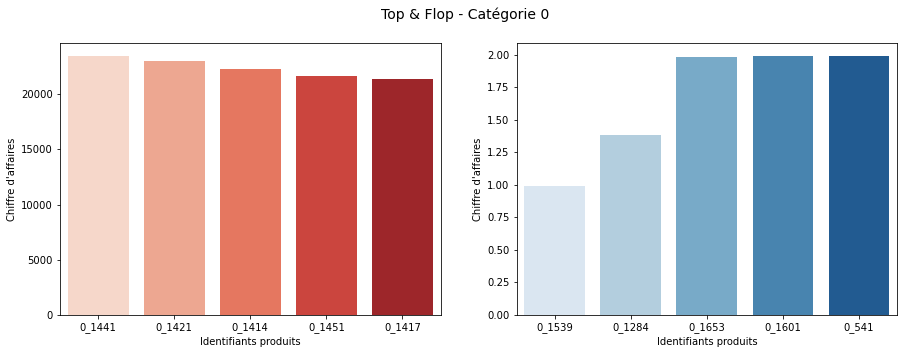

In [16]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.suptitle("Top & Flop - Catégorie 0", size=14)

sns.barplot(x="id_prod", y="prix",
            data=data.loc[data["catégorie"] == 0].groupby("id_prod").sum().sort_values("prix", ascending=False).reset_index().head(), 
            estimator=sum,
            ci=None,
            palette="Reds",
            ax=ax1) 

ax1.set_ylabel("Chiffre d'affaires", size = 10)
ax1.set_xlabel("Identifiants produits", size = 10)

sns.barplot(x="id_prod", y="prix", 
            data=data.loc[data["catégorie"] == 0].groupby("id_prod").sum().sort_values("prix", ascending=True).reset_index().head(), 
            estimator=sum,
            ci=None,
            palette="Blues",
            ax=ax2)

ax2.set_ylabel("Chiffre d'affaires", size = 10)
ax2.set_xlabel("Identifiants produits", size = 10)

plt.show()

Catégorie 1

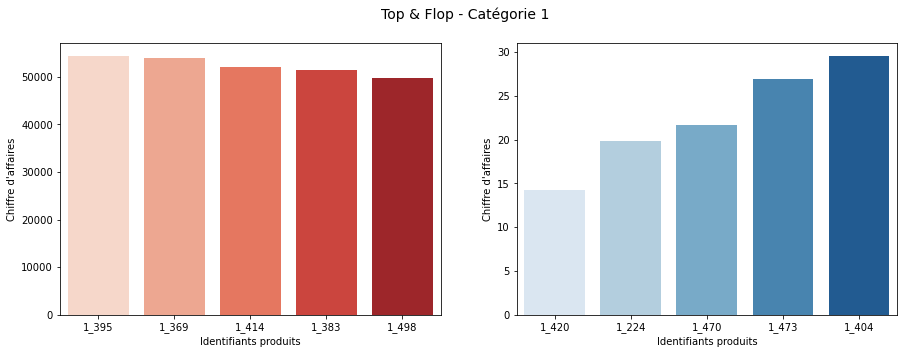

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.suptitle("Top & Flop - Catégorie 1", size=14)

sns.barplot(x="id_prod", y="prix",
            data=data.loc[data["catégorie"] == 1].groupby("id_prod").sum().sort_values("prix", ascending=False).reset_index().head(), 
            estimator=sum,
            ci=None,
            palette="Reds",
            ax=ax1) 

ax1.set_ylabel("Chiffre d'affaires", size = 10)
ax1.set_xlabel("Identifiants produits", size = 10)

sns.barplot(x="id_prod", y="prix", 
            data=data.loc[data["catégorie"] == 1].groupby("id_prod").sum().sort_values("prix", ascending=True).reset_index().head(), 
            estimator=sum,
            ci=None,
            palette="Blues",
            ax=ax2)

ax2.set_ylabel("Chiffre d'affaires", size = 10)
ax2.set_xlabel("Identifiants produits", size = 10)

plt.show()

Catégorie 2

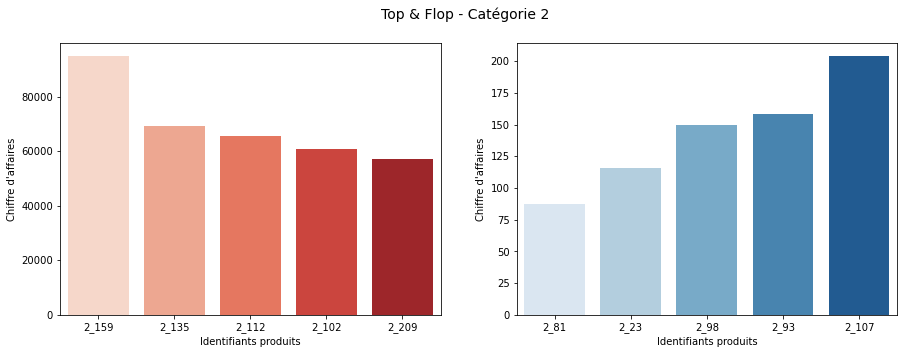

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.suptitle("Top & Flop - Catégorie 2", size=14)

sns.barplot(x="id_prod", y="prix",
            data=data.loc[data["catégorie"] == 2].groupby("id_prod").sum().sort_values("prix", ascending=False).reset_index().head(), 
            estimator=sum,
            ci=None,
            palette="Reds",
            ax=ax1) 

ax1.set_ylabel("Chiffre d'affaires", size = 10)
ax1.set_xlabel("Identifiants produits", size = 10)

sns.barplot(x="id_prod", y="prix", 
            data=data.loc[data["catégorie"] == 2].groupby("id_prod").sum().sort_values("prix", ascending=True).reset_index().head(), 
            estimator=sum,
            ci=None,
            palette="Blues",
            ax=ax2)

ax2.set_ylabel("Chiffre d'affaires", size = 10)
ax2.set_xlabel("Identifiants produits", size = 10)

plt.show()

###### Top ventes par genre

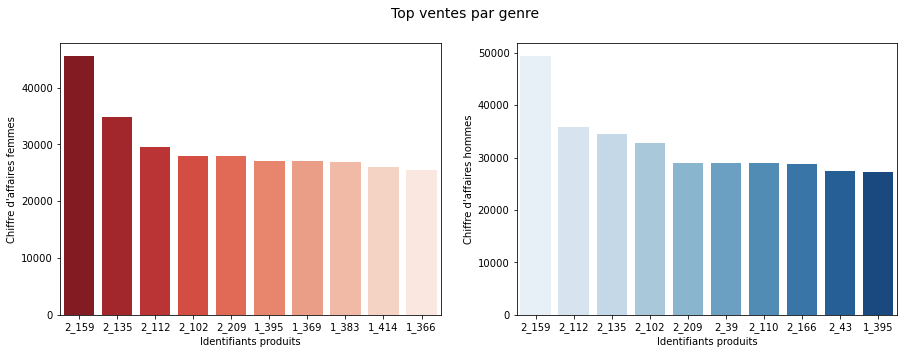

In [19]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.suptitle("Top ventes par genre", size=14)

sns.barplot(x="id_prod", y="prix",
            data=data.loc[data["genre"] == "f"].groupby("id_prod").sum().sort_values("prix", ascending=False).reset_index().head(10), 
            estimator=sum,
            ci=None,
            palette="Reds_r",
            ax=ax1)

ax1.set_ylabel("Chiffre d'affaires femmes", size = 10)
ax1.set_xlabel("Identifiants produits", size = 10)

sns.barplot(x="id_prod", y="prix", 
            data=data.loc[data["genre"] == "m"].groupby("id_prod").sum().sort_values("prix", ascending=False).reset_index().head(10), 
            estimator=sum,
            ci=None,
            palette="Blues",
            ax=ax2)

ax2.set_ylabel("Chiffre d'affaires hommes", size = 10)
ax2.set_xlabel("Identifiants produits", size = 10)

plt.show()

### 3) Profil des clients <a class="anchor" id="section_2_3"></a>

Nous avons peu d'informations qualitatives concernant nos clients, si ce n'est leurs années de naissance et donc par déduction leurs âges.

Essayons alors de dresser un portrait de l'âge de notre clientèle grâce à différente pyramide des âges.

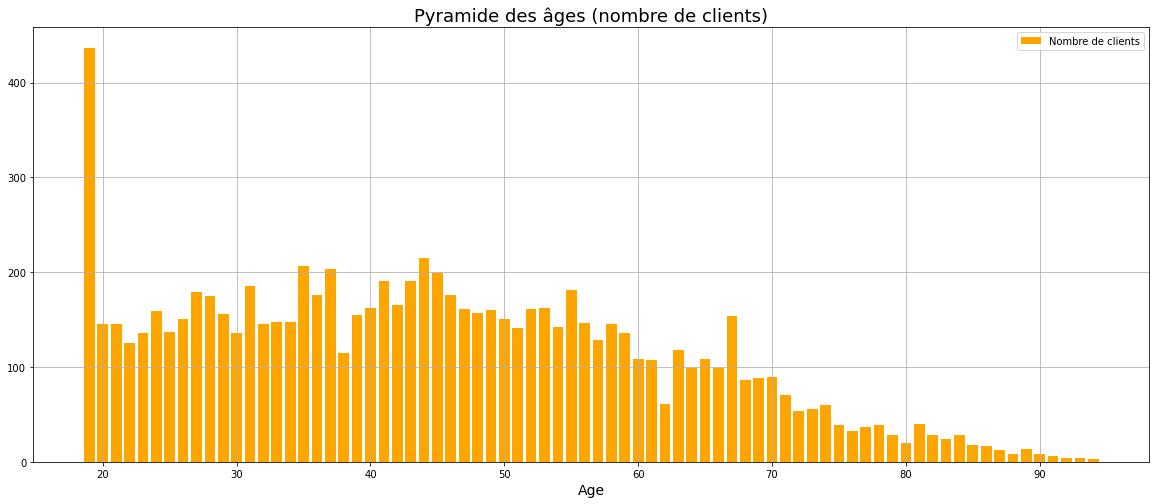

In [20]:
age_count = data_cl["âge"].value_counts().reset_index()

plt.figure(figsize=(20, 8))
plt.title("Pyramide des âges (nombre de clients)", size=18)

plt.bar(x=age_count["index"], height=age_count["âge"], label="Nombre de clients", color="orange")

plt.legend()
plt.ylabel("", size = 10)
plt.xlabel("Age", size = 14)
plt.grid(True)

plt.show()

On observe une répartition relativement homogène de nos clients selon leur âge.

Néanmoins le nombre de clients âgés de 19ans semble étrange. Cela peut surement être expliqué par une limite d'âge fixée afin de réaliser un achat sur le site. Il est possible que beaucoup de mineurs aient dû "mentir" sur leur âge afin de réaliser leurs achats.

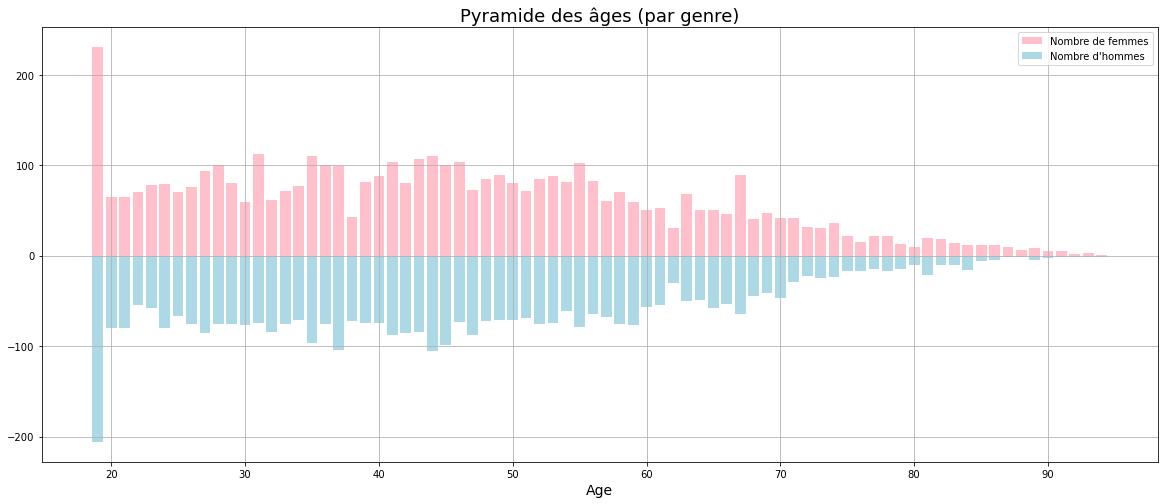

In [21]:
#création de 2 df, un pour les données des femmes et un pour les données des hommes:
f = data_cl.loc[data_cl["genre"] == "f"]
f_count = f["âge"].value_counts().reset_index()
h = data_cl.loc[data_cl["genre"] == "m"]
h_count = h["âge"].value_counts().reset_index()
h_count["âge"] = h_count["âge"] * -1 #on passe le nombre de clients homme en négatif afin de pouvoir les afficher en face des femmes

plt.figure(figsize=(20, 8))
plt.title("Pyramide des âges (par genre)", size=18)

plt.bar(x=f_count["index"], height=f_count["âge"], label="Nombre de femmes", color="pink")
plt.bar(x=h_count["index"], height=h_count["âge"], label="Nombre d'hommes", color="lightblue")

plt.legend(loc="upper right")
plt.ylabel("", size = 10)
plt.xlabel("Age", size = 14)
plt.grid(True)
           
plt.show()

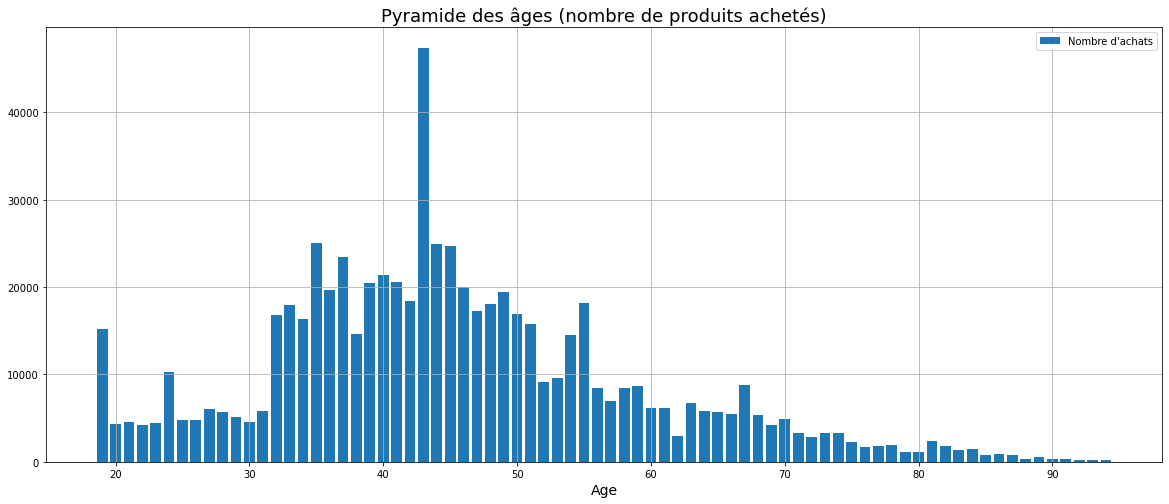

In [22]:
age_ventes = data.groupby(["âge"])["ventes"].sum().reset_index()

plt.figure(figsize=(20, 8))
plt.title("Pyramide des âges (nombre de produits achetés)", size=18)

plt.bar(x=age_ventes["âge"], height=age_ventes["ventes"], label="Nombre d'achats")

plt.legend()
plt.ylabel("", size = 10)
plt.xlabel("Age", size = 14)
plt.grid(True)

plt.show()

On constate que les "30-50ans" ont tendance à réaliser bien plus d'achats que les 20-30ans, ce qui peut s'expliquer par un pouvoir d'achat plus important du fait de leur stabilité économique. Les clients de 19ans représente une anomalie, comme observé plus tôt.

Passé 50ans le nombre d'achat à tendance à décroitre, suivant presque exactement la baisse du nombre de client. Peut-être aussi dû au fait qu'il s'agit d'achats fait sur internet, moins accessibles aux personnes plus âgées.

Enfin, certains nombre d'achats réalisés paraissent anormalement élevés (ex: les clients de 43 et 24ans réalise 2 fois plus d'achats que les autres personnes de leur catégorie d'âge)

##### Classement des clients (par nombre d'achat):

In [23]:
#Top 10 des clients ayant achetés le plus d'articles:
ventes_count = data.groupby(["client_id", "âge"])["ventes"].sum().reset_index().sort_values("ventes", ascending=False)
ventes_count.head(10)

,client_id,âge,ventes
677,c_1609,43,25488
6337,c_6714,55,9187
2724,c_3454,54,6773
4388,c_4958,24,5195
2513,c_3263,38,403
1268,c_2140,46,402
1772,c_2595,49,398
1197,c_2077,39,384
708,c_1637,35,380
7120,c_7421,45,379


4 clients se distinguent très clairement, avec un nombre d'achats bien plus importants que la majorité. On peut remarquer aussi que les âges de ces clients correspondent aux âges dont le nombre d'achats semblaient anormales sur les pyramides précédentes.

Graphiquement cette différence est d'autant plus impressionante:

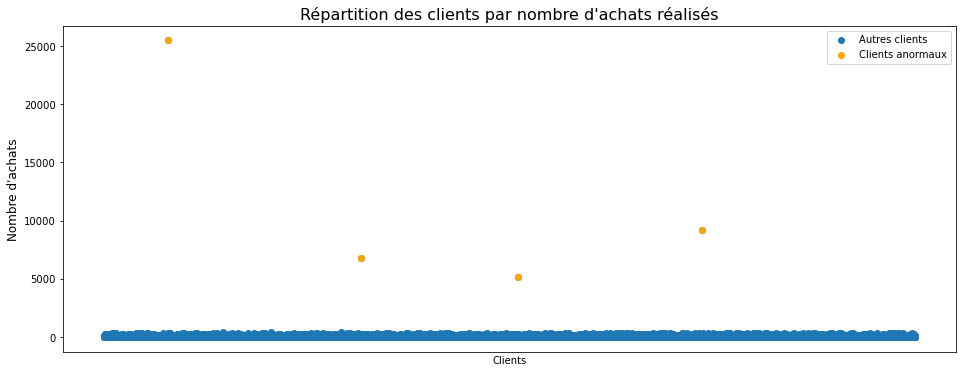

In [24]:
#On isole les "valeurs anormales" dans un autre df:
v_out = ventes_count.loc[ventes_count["ventes"] > 500]
v_in = ventes_count.loc[ventes_count["ventes"] <= 500]

plt.figure(figsize=(16, 6))
plt.title("Répartition des clients par nombre d'achats réalisés",size=16)

plt.scatter(ventes_count["ventes"].index, ventes_count["ventes"], label="Autres clients")
plt.scatter(v_out["ventes"].index, v_out["ventes"], label="Clients anormaux", c='orange')

plt.legend()
plt.xlabel("Clients")
plt.xticks([])
plt.ylabel("Nombre d'achats", size=12)

plt.show()

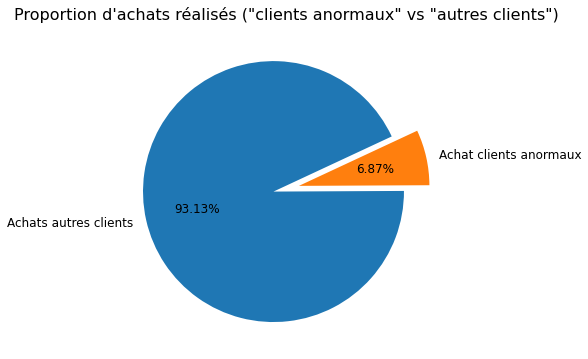

In [25]:
plt.figure(figsize=(6, 6))
plt.title('Proportion d\'achats réalisés ("clients anormaux" vs "autres clients")',size=16)

labels = 'Achats autres clients', 'Achat clients anormaux' 
sizes = [v_in["ventes"].sum(), v_out["ventes"].sum()]
explode = (0.1, 0.1)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%',
        shadow=False, startangle=25, textprops={'size':12})

plt.show()

La part des achats de ses 4 clients "anormaux" représente un peu moins de 7% des achats réalisés sur notre site. Ils sont donc très largement surreprésentés. 

Un client réalisant en moyenne 79 achats, comparé aux milliers réalisés par ces 4 clients, ces clients pourraient-ils influer les tendances d'achats observées plus tôt ?

In [26]:
#df avec les 4 clients "outliers":
c_out = data.loc[(data["client_id"] == "c_1609") | 
               (data["client_id"] =="c_3454") | 
               (data["client_id"] =="c_4958") | 
               (data["client_id"] =="c_6714")]

#df sans les 4 clients "outliers":
c_in = data.loc[(data["client_id"] != "c_1609") & 
               (data["client_id"] !="c_3454") & 
               (data["client_id"] !="c_4958") & 
               (data["client_id"] !="c_6714")]

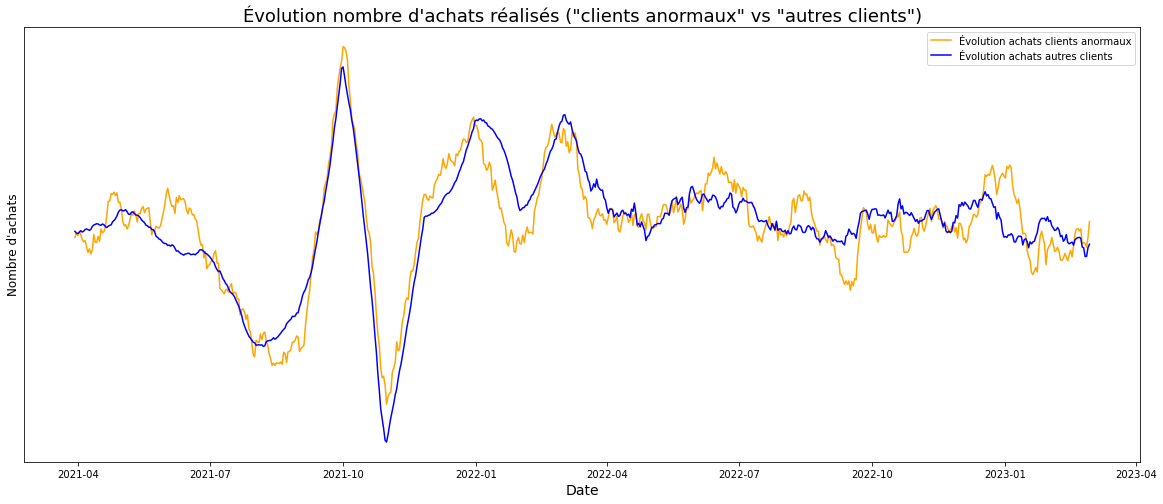

In [27]:
ca_out = c_out.groupby(["date_simple"])["ventes"].sum().reset_index().sort_values("date_simple")
ca_out["moyenne_mobile_1m"] = ca_out["ventes"].rolling(30).mean()

ca_in = c_in.groupby(["date_simple"])["ventes"].sum().reset_index().sort_values("date_simple")
ca_in["moyenne_mobile_1m"] = ca_in["ventes"].rolling(30).mean()

plt.figure(figsize=(20, 8))
plt.title('Évolution nombre d\'achats réalisés ("clients anormaux" vs "autres clients")', size=18)

x=ca_out["date_simple"]
y=((ca_out["moyenne_mobile_1m"]-ca_out["moyenne_mobile_1m"].mean())/np.std(ca_out["moyenne_mobile_1m"]))
y1=((ca_in["moyenne_mobile_1m"]-ca_in["moyenne_mobile_1m"].mean())/np.std(ca_in["moyenne_mobile_1m"]))
#on normalise les achats afin d'observer les tendances sans subir l'influence des quantités

plt.plot(x, y, color="orange", label="Évolution achats clients anormaux")
plt.plot(x, y1, color="blue", label="Évolution achats autres clients")

plt.legend()
plt.yticks([])
plt.ylabel("Nombre d'achats", size=12)
plt.xlabel("Date", size=14)

plt.show()

Malgrè leur nombre d'achats beaucoup plus importants, ces 4 clients ne semble pas influencer le total des achats réalisés. En effet ces derniers suivent assez précisemment la tendance globale.

##### Mesure de la concentration:

Courbe de **LORENZ**:

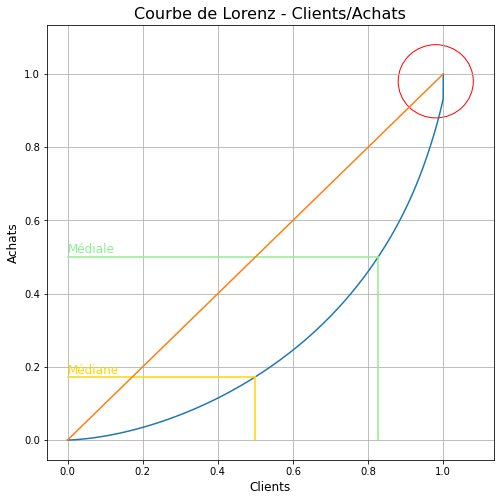

In [28]:
from matplotlib.patches import Circle

achats = ventes_count["ventes"].values
n = len(achats)
lorenz = np.cumsum(np.sort(achats)) / achats.sum()
lorenz = np.append([0],lorenz)

mediale = len(lorenz[lorenz<=0.5])/len(lorenz)
mediane = lorenz[int(len(lorenz)/2)]

xaxis = np.linspace(0-1/n,1+1/n,n+1)

plt.figure(figsize=(8, 8))
plt.title("Courbe de Lorenz - Clients/Achats", size=16)

plt.plot(xaxis, lorenz)
#mediale
plt.plot([0, mediale], [0.5, 0.5], color = "lightgreen", label = "mediale")
plt.plot([mediale, mediale], [0, 0.5], color = "lightgreen")
plt.text(0, 0.52, "Médiale", fontsize=12, color="lightgreen", verticalalignment='center')
#mediane
plt.plot([0.5,0.5],[0, mediane],color= "gold",label = "mediane")
plt.plot([0,0.5],[mediane,mediane], color= "gold")
plt.text(0, 0.19, "Médiane", fontsize=12, color="gold", verticalalignment='center')
# la premiére bisectrice
plt.plot([0,1],[0,1])

plt.xlabel("Clients", size=12)
plt.ylabel("Achats", size=12)
plt.grid(True)

circle = Circle((0.98, 0.98), 0.1, fill=False, color="red")
plt.gca().add_patch(circle)

plt.show()

Indice de **GINI**:
- Mesure l'aire présente entre la première bissectrice (répartition égalitaire) et la courbe de Lorenz

Un indice de GINI égal à **0** signifie que la distribution des achats est **parfaitement égalitaire**, à l'inverse un indice égal à **1** est synonyme de distribution **parfaitement inégalitaire**.

In [29]:
AUC = (lorenz.sum() -lorenz[-1]/2 -lorenz[0]/2)/n
S = 0.5 - AUC
gini = 2*S
gini

0.4981767420909652

Dans notre cas, et comme la courbe de LORENZ le montre clairement, la distribution des achats chez nos clients n'est pas égalitaire du tout (gini~0.5).

En effet on retrouve une tendance proche de la loi de Pareto:
- Un peu moins de 20% des plus gros acheteurs réalisent autant d'achats que le reste des clients.
- 80% des achats totaux sont réalisés par la moitié supérieur des acheteurs.

On observe aussi (dans le cercle rouge) nos 4 clients "anormaux" qui du fait de leur nombre d'achats très importants marquent une "dernière marche" quasi verticale.

## III) Demandes de Julie: <a class="anchor" id="chapter3"></a>

Une analyse plus ciblée sur les clients : l’objectif est de comprendre le comportement de nos clients en ligne, pour pouvoir ensuite comparer avec la connaissance acquise via nos librairies physiques:
- le lien entre le genre d’un client et les catégories des livres achetés
- le lien entre l’âge des clients et le montant total des achats, la fréquence d’achat, la taille du panier moyen et  les catégories des livres achetés

***
Nous avons précédemment vu que 4 clients pouvaient être considérés comme des outliers du fait de leur nombre d'achats très importants.
Bien que ceux-ci ne semblent pas influencer les tendances de ventes, on choisit de se séparer des ces données afin de réaliser les tests statistiques à venir, certains étant particulièrement sensibles aux outliers.
Nous utiliserons ainsi un dataframe "test" correspondant au dataframe "c_in" créé plus tôt, sans les 4 clients "anormaux".

In [30]:
test = c_in

***

### 1) Déclaration des fonctions <a class="anchor" id="section_3_1"></a>

##### Fonction - Chi2

Le test du Chi2 permet de tester l'hypohèse nulle selon laquelle 2 variables aléatoires qualitatives sont indépendantes.

In [31]:
def chi2_test(df, X, Y):
    alpha = 0.05
    
    #tableau de contingence
    cont = df[[X,Y]].pivot_table(index=X, columns=Y, aggfunc=len, margins=False)
    
    #calcul de chi2, p_value, degré de liberté et les valeurs attendues:
    (chi2, p_value, ddl, exp) = stats.chi2_contingency(cont)
    
    #retourne chi2, p_value, degré de liberté et les valeurs attendues:
    return(chi2, p_value, ddl, exp)

##### Fonction - Coefficient de Cramer

Le coefficient de Cramer permet de mesurer l'intensité de la relation entre 2 variables aléatoires qualitatives significativement dépendantes.

Ici, on intègre donc la fonction "Chi2" afin de tester l'indépendance des variables avant de mesurer leur lien.

In [32]:
def chi2_cramer_test(df, X, Y):
    print("On teste ici l'hypothèse nulle (H0) selon laquelle les variables",X,"et",Y, "sont indépendantes:")
    alpha = 0.05
    
    (chi2, p_value, ddl, exp) = chi2_test(df, X, Y) #on récupère le résultat du test du chi2
    
    if p_value < alpha:
        print("p_value est inférieur à", alpha)
        print("L'hypothèse nulle est donc rejetée ---> H1: Les variables", X, "et", Y, "sont dépendantes de manière significative.")
        
        V = math.sqrt(chi2/(len(df)*ddl))
        if V < 0.10:
            rel = "très faible"
        elif V < 0.20:
            rel = "faible"
        elif V < 0.30:
            rel = "moyenne"
        elif V >= 0.30:
            rel = "forte"     
            
        print("V =", V)   
        print("L'intensité de le relation entre les deux variables est", rel, ".")
    
    else:
        print("P est supérieur à", alpha)
        print("L'hypothèse nulle est donc acceptée ---> H0: Les variables", X, "et", Y, "sont indépendantes.")

##### Fonction - Test de Shapiro:

Le test de Shapiro_Wilk permet de tester l'hypohèse nulle selon laquelle un échantillon (ici nos variables) est issu d'une population normalement distribuée.

In [33]:
def shapiro_test(df, x):
    print("Ici on cherche à tester l'hypothèse nulle (H0): la variable", x, "suit une loi normale.")
    alpha = 0.05

    p_value = stats.shapiro(df[x])[1]
    print("p_value =", p_value)
    
    if p_value < alpha:
        print("p_value est inférieur à", alpha)
        print("L'hypothèse nulle est donc rejetée ---> H1 est acceptée: La variable", x, "ne suit pas une loi normale")
        
    else:
        print("p_value est supérieur à", alpha)
        print("L'hypothèse nulle est donc acceptée ---> H0 est acceptée: La variable", x, "suit une loi normale")

##### Fonction - Test de Spearman:

Le test de Spearman permet de tester l'hypohèse nulle selon laquelle 2 variables aléatoires quantitatives sont indépendantes.
Il consiste à trouver un coefficient de corrélation (rho), non pas entre les valeurs prises par les deux variables mais entre les rangs de ces valeurs.

In [34]:
def spearman_test(df, x, y):
    print("On teste ici l'hypothèse nulle (H0) selon laquelle les variables",x,"et",y, "sont indépendantes:")
    alpha = 0.05

    rho, pvalue = stats.spearmanr(df[x], df[y])
    
    if pvalue < alpha:
        print("p_value est inférieur à", alpha)
        print("L'hypothèse nulle est donc rejetée ---> H1: Les variables", x, "et", y, "sont dépendantes de manière significative.")
    
        if abs(rho) < 0.10:
            corr = "négligeable"
        elif abs(rho) < 0.20:
            corr = "faible"
        elif abs(rho) < 0.40:
            corr = "modérée"
        elif abs(rho) < 0.60:
            corr = "plutôt forte"
        elif abs(rho) < 0.80:
            corr = "forte"
        elif abs(rho) >= 0.80:
            corr = "très forte"
        print("Le coefficient rho est égal à:", rho)
        
        if rho < 0:
            print("Le coefficient rho indique une corrélation négative", corr, "entre les 2 variables.")
        else:
            print("Le coefficient rho indique une corrélation positive", corr, "entre les 2 variables.")
    
    else:
        print("p_value est supérieur à", alpha)
        print("L'hypothèse nulle est donc acceptée ---> H0: Les variables", x, "et", y, "sont indépendantes.")

### 2) Lien entre Genre d'un client et Catégorie des livres achetés  <a class="anchor" id="section_3_2"></a>

Nous avons ici 2 variables aléatoires qualitatives.

Afin de tester leur indépendance nous allons donc réaliser un test de Chi2 puis de Cramer (définis plus haut):

In [35]:
chi2_cramer_test(test, "genre", "catégorie")

On teste ici l'hypothèse nulle (H0) selon laquelle les variables genre et catégorie sont indépendantes:
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1: Les variables genre et catégorie sont dépendantes de manière significative.
V = 0.003995465760185709
L'intensité de le relation entre les deux variables est très faible .


On peut aussi essayer de représenter cette corrélation grâce à une carte de chaleur (heatmap) afin notamment d'identifier la source de cette corrélation:

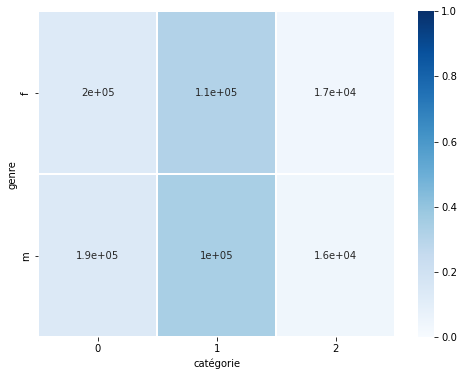

In [36]:
cont_gencat = test[["genre","catégorie"]].pivot_table(index="genre", columns="catégorie", aggfunc=len, margins=True)

totalx = cont_gencat.loc[:,["All"]] #ligne "All"
totaly = cont_gencat.loc[["All"],:] #colonne "All"
n = len(test) #population
indep = totalx.dot(totaly) / n # tableau (produit matriciel) représentant le cas d'indépendance (fi x nj = ni x nj / n)

measure = (cont_gencat-indep)**2/indep # différence entre nij et ni x nj pour chaque case du tableau
xi_n = measure.sum().sum() # nombre de contributions
table = measure/xi_n # normalisation des écarts grâce au total de contributions

plt.figure(figsize=(8, 6))

sns.heatmap(table.iloc[:-1,:-1], annot=cont_gencat.iloc[:-1,:-1], vmin=0, vmax=1, cmap="Blues", linewidth=2)

plt.show()

On comprend pourquoi l'intensité de la relation est jugée "trés faible". En effet aucune valeur de semble fortement influencée la relation entre les variables genre et catégorie.

### 3) Lien entre Age des clients et Montant total des achats <a class="anchor" id="section_3_3"></a>

Ici nous avons une variable qualitative et une variable quantitative.

Afin de savoir quel test effectuer pour tester l'indépendance de ces variables nous devons d'abord vérifier certains paramètres:
- la normalité des variables
- l'égalité des variances (potentiellement)

***

Nous allons d'abord discrétiser nos données par client, afin d'avoir leurs âges et le montant total de leurs achats respectifs. 

In [37]:
age_achats = test.groupby(["client_id", "âge"])["prix"].sum().reset_index()
age_achats.rename(columns={"prix": "total_achats"}, inplace=True)

age_achats.head()

,client_id,âge,total_achats
0,c_1,68,558.18
1,c_10,67,1353.60
2,c_100,31,254.85
3,c_1000,57,2261.89
4,c_1001,41,1812.86


Puis, comme vu plus haut, on teste la normalité de nos variables.

D'abord graphiquement:

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Montant total des achats')

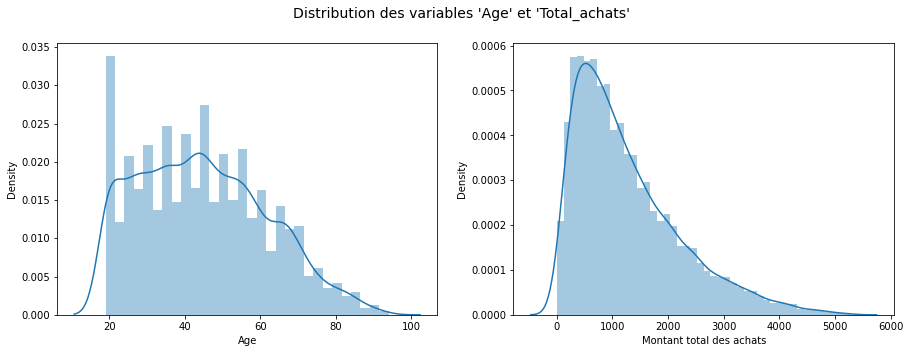

In [38]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
plt.suptitle("Distribution des variables 'Age' et 'Total_achats'", size=14)

sns.distplot(age_achats["âge"], ax=ax1)
ax1.set_xlabel("Age", size = 10)

sns.distplot(age_achats["total_achats"], ax=ax2)
ax2.set_xlabel("Montant total des achats", size = 10)

A première vue, la distribution d'aucune des 2 variables ne semble suivre une loi normale.

Utilisons un test de **Shapiro** afin de s'assurer de cela statistiquement:

In [39]:
shapiro_test(age_achats, "âge")

print("\n", "-"*100, "\n")

shapiro_test(age_achats, "total_achats")

Ici on cherche à tester l'hypothèse nulle (H0): la variable âge suit une loi normale.
p_value = 4.6241265855454276e-39
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1 est acceptée: La variable âge ne suit pas une loi normale

 ---------------------------------------------------------------------------------------------------- 

Ici on cherche à tester l'hypothèse nulle (H0): la variable total_achats suit une loi normale.
p_value = 0.0
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1 est acceptée: La variable total_achats ne suit pas une loi normale


D:\Anaconda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


On a donc bien la confirmation statistique que nos variables ne suivent pas la loi normale.

Nos variables étant **non-paramétriques**, pas besoin de tester leurs variances, nous choisissons de réaliser un test de **Spearman** afin de mesurer leure corrélation:

In [40]:
spearman_test(age_achats, "âge", "total_achats")

On teste ici l'hypothèse nulle (H0) selon laquelle les variables âge et total_achats sont indépendantes:
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1: Les variables âge et total_achats sont dépendantes de manière significative.
Le coefficient rho est égal à: -0.18510194715356787
Le coefficient rho indique une corrélation négative faible entre les 2 variables.


Le coefficient "rho" est de -0.185. Ceci nous indique une **relation négative** entre les deux variables, c'est à dire que si l'une des deux variable augmente l'autre tend à baisser.
Dans notre cas, plus l'âge des clients augmente plus ils tendent à avoir un total d'achats qui diminue.

La p_value très largement inférieur à 0.05 nous indique que cette corrélation est bien **significative**, mais **faible** puisque rho est compris entre 0.10 et 0.20.

***

Essayons de constater cette corrélation graphiquement, en utilisant la moyenne du total d'achats par âge:

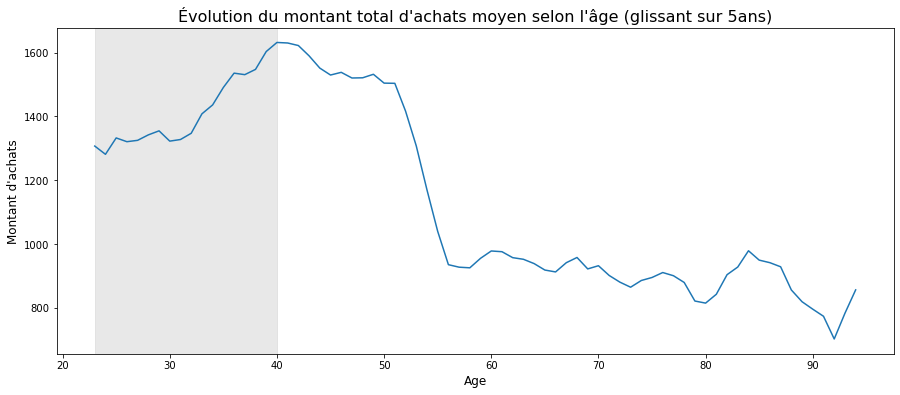

In [41]:
moy_achat = age_achats.groupby("âge").mean().reset_index()
moy_achat["moy_mob_5a"] = moy_achat["total_achats"].rolling(5).mean()

plt.figure(figsize=(15, 6))
plt.title("Évolution du montant total d'achats moyen selon l'âge (glissant sur 5ans)", size=16)

plt.plot(moy_achat["âge"], moy_achat["moy_mob_5a"])

plt.ylabel("Montant d'achats", size = 12)
plt.xlabel("Age", size = 12)
plt.axvspan(23, 40, color="lightgray", alpha=0.5)

plt.show()

Au delà de 40 ans on constate une corrélation négative claire entre l'âge et le montant total des achats réalisés par nos clients. Cependant cette relation est inversé en dessous de 40 ans, où l'augmentation de l'âge semble entrainait une augmentation du total d'achats. 

Ceci peut expliquer la faible valeur de rho trouvée grâce au test de Spearman.

*** 

Afin de confirmer le résultat du test de Spearman nous allons réaliser un autre test statistique.

Pour cela nous allons transformer la variable "âge" en variable qualitative, en créant des groupes d'âges de 20ans:

In [42]:
age_achats.loc[(age_achats["âge"] < 30), "age_group"] = "30-"
age_achats.loc[(age_achats["âge"] > 29) & (age_achats["âge"] < 50), "age_group"] = "30-50"
age_achats.loc[(age_achats["âge"] > 49) & (age_achats["âge"] < 70), "age_group"] = "50-70"
age_achats.loc[(age_achats["âge"] > 69), "age_group"] = "70+"

Nous pouvons ensuite, grâce à une boite à moustache, avoir un premier aperçu de la distribution au sein de nos groupes d'âges:

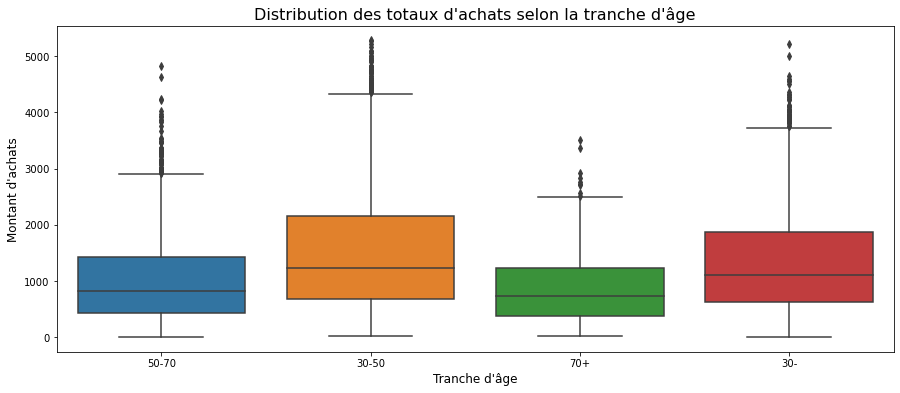

In [43]:
plt.figure(figsize=(15, 6))
plt.title("Distribution des totaux d'achats selon la tranche d'âge", size=16)

sns.boxplot(y=age_achats["total_achats"], x=age_achats["age_group"], data=test, orient="v")

plt.ylabel("Montant d'achats", size = 12)
plt.xlabel("Tranche d'âge", size = 12)

plt.show()

Graphiquement, il semble bien y avoir une influence de l'âge sur le total d'achats.

Encore une fois, testons cela statistiquement:

Nos variables étant non-paramétriques nous allons réaliser un test de **Kruskal-Wallis**, qui propose comme hypothèse nulle que les groupes sont identiquement distribués. Pour cela, il en compare les rangs de leur distribution.

In [44]:
#on crée au sein de notre df une variable permettant de qualifié nos individus avec leur tranche d'âge
Trent_moins = age_achats["total_achats"].loc[age_achats["age_group"] == "30-"]
Trent_cinq = age_achats["total_achats"].loc[age_achats["age_group"] == "30-50"]
Cinq_soix = age_achats["total_achats"].loc[age_achats["age_group"] == "50-70"]
Soix_plus = age_achats["total_achats"].loc[age_achats["age_group"] == "70+"]

In [45]:
#on effectue le teste de Kruskal-Wallis grâce à la méthode du même nom:
stats.kruskal(Trent_moins, Trent_cinq, Cinq_soix, Soix_plus)

KruskalResult(statistic=515.0091860644428, pvalue=2.6660271226585677e-111)

La p_value, très largement inférieur à 0.05, indique qu'au moins un groupe a une distribution différente des autres groupes. **Ainsi on ne peut admettre H0 et on admet qu'il y a bien une corrélation entre l'âge et le total d'achats réalisé.**

Cela confirme bien le résultat du premier test réalisé.

### 4) Lien entre Age des clients et Fréquence d'achat <a class="anchor" id="section_3_4"></a>

Nous prenons ici pour fréquence moyenne d'achat le nombre de sessions d'achats de chaque clients sur le nombre total de jours étudiée. Soit donc le nombre de jours moyen séparant 2 sessions d'achat.

In [46]:
#calcul du nombre de jours total étudiés:
from datetime import date
p_jour = date(2021, 3, 1)
d_jour = date(2023, 2, 28)
delta = d_jour - p_jour
print("Nos données s'étalent sur un total de", delta.days, "jours.")

Nos données s'étalent sur un total de 729 jours.


Ainsi un client avec une fréquence d'achat "courte" est un client qui revient plus souvent réaliser des achats sur notre site qu'un client avec une fréquence d'achat "longue".

In [47]:
age_frequence = test.groupby(["client_id", "âge"])["session_id"].nunique().reset_index()
age_frequence.rename(columns={"session_id": "session_nb"}, inplace=True)
age_frequence["frequence"] = delta.days/age_frequence["session_nb"]

age_frequence.head()

,client_id,âge,session_nb,frequence
0,c_1,68,33,22.090909
1,c_10,67,34,21.441176
2,c_100,31,5,145.800000
3,c_1000,57,93,7.838710
4,c_1001,41,47,15.510638


Nous sommes ici, encore une fois, en présence de 2 variables quantitatives et souhaitons donc tester leur normalité. On sait déjà que la variable "âge" ne suit pas une loi normale.

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, "Fréquence d'achats")

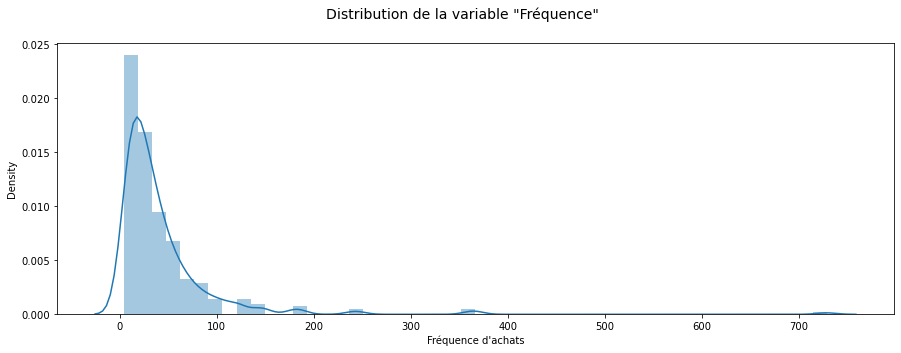

In [48]:
plt.figure(figsize=(15,5))
plt.suptitle('Distribution de la variable "Fréquence"', size=14)

sns.distplot(age_frequence["frequence"])

plt.xlabel("Fréquence d'achats", size=10)

Visuellement la variable ne semble pas suivre une loi normale, et le test de Shapiro va le confirmer:

In [49]:
shapiro_test(age_frequence, "frequence")

Ici on cherche à tester l'hypothèse nulle (H0): la variable frequence suit une loi normale.
p_value = 0.0
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1 est acceptée: La variable frequence ne suit pas une loi normale


D:\Anaconda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Nous nous retrouvons donc à nouveau dans le cas où le test de Spearman est le plus adequat à réaliser afin de tester l'indépendance de ces 2 variables.

In [50]:
spearman_test(age_frequence, "âge", "frequence")

On teste ici l'hypothèse nulle (H0) selon laquelle les variables âge et frequence sont indépendantes:
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1: Les variables âge et frequence sont dépendantes de manière significative.
Le coefficient rho est égal à: -0.21234739496458024
Le coefficient rho indique une corrélation négative modérée entre les 2 variables.


Observons cette corrélation graphiquement:

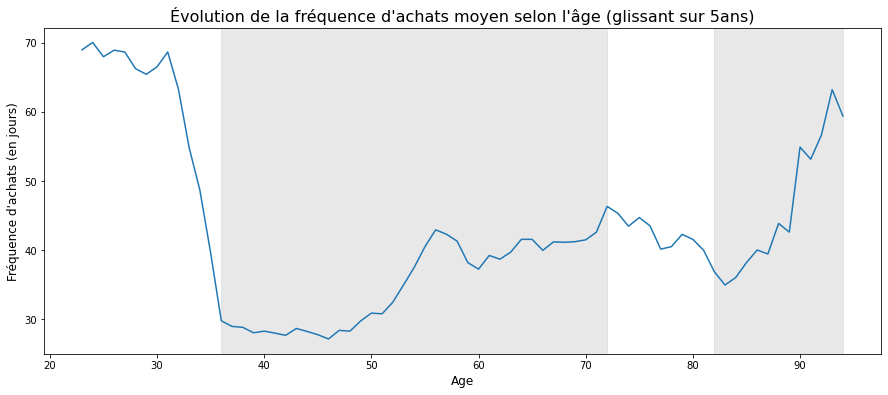

In [51]:
moy_freq = age_frequence.groupby("âge").mean().reset_index()
moy_freq["moy_mob_5a"] = moy_freq["frequence"].rolling(5).mean()

plt.figure(figsize=(15, 6))
plt.title("Évolution de la fréquence d'achats moyen selon l'âge (glissant sur 5ans)", size=16)

plt.plot(moy_freq["âge"], moy_freq["moy_mob_5a"])

plt.ylabel("Fréquence d'achats (en jours)", size = 12)
plt.xlabel("Age", size = 12)
plt.axvspan(36, 72, color="lightgray", alpha=0.5)
plt.axvspan(82, 94, color="lightgray", alpha=0.5)

plt.show()

Comme pour le test précédent nous sommes dans le cas d'une corrélation négative. Dans notre cas cela signifie que plus l'âge augmente plus le laps de temps entre les session à tendance à diminuer. 

Cependant on observe plusieurs tranche d'âge au sein desquelles l'effet est inversé (zones grisées).

Ceci peut donc expliquer, encore une fois, la faible valeur de rho trouvée grâce au test de Spearman.

### 5) Lien entre Age des clients et Taille du panier moyen <a class="anchor" id="section_3_5"></a>

Ici nous prenons pour "panier moyen" le montant moyen des sessions d'achats de nos clients.

In [52]:
age_panier = test.groupby(["client_id", "âge", "session_id"])["prix"].sum().reset_index()
age_panier.rename(columns={"prix": "prix_panier"}, inplace=True)

age_panier = age_panier.groupby(["client_id", "âge"])["prix_panier"].mean().reset_index()
age_panier.rename(columns={"prix_panier": "moy_panier"}, inplace=True)

age_panier.head()

,client_id,âge,moy_panier
0,c_1,68,16.914545
1,c_10,67,39.811765
2,c_100,31,50.970000
3,c_1000,57,24.321398
4,c_1001,41,38.571489


Nous sommes ici, encore une fois, en présence de 2 variables quantitatives et souhaitons donc tester leur normalité. On sait déjà que la variable "âge" ne suit pas une loi normale.

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Montant moyen du panier')

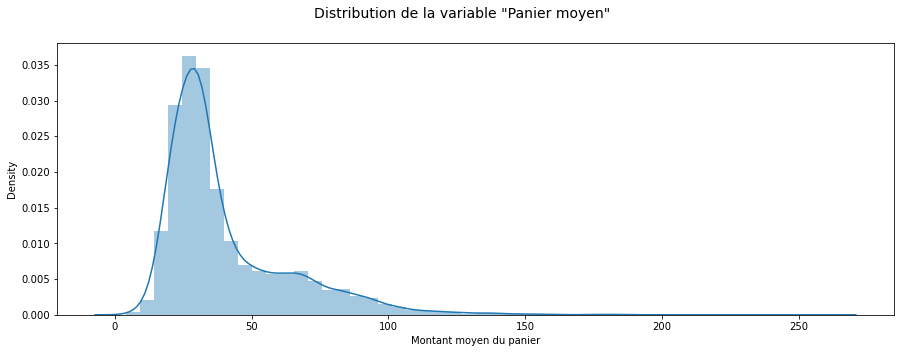

In [53]:
plt.figure(figsize=(15,5))
plt.suptitle('Distribution de la variable "Panier moyen"', size=14)

sns.distplot(age_panier["moy_panier"])

plt.xlabel("Montant moyen du panier", size=10)

Visuellement la variable ne semble pas suivre une loi normale, et le test de Shapiro va le confirmer:

In [54]:
shapiro_test(age_panier, "moy_panier")

Ici on cherche à tester l'hypothèse nulle (H0): la variable moy_panier suit une loi normale.
p_value = 0.0
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1 est acceptée: La variable moy_panier ne suit pas une loi normale


D:\Anaconda\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Nous nous retrouvons donc à nouveau dans le cas où le test de Spearman est le plus adequat à réaliser afin de tester l'indépendance de ces 2 variables.

In [55]:
spearman_test(age_panier, "âge", "moy_panier")

On teste ici l'hypothèse nulle (H0) selon laquelle les variables âge et moy_panier sont indépendantes:
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1: Les variables âge et moy_panier sont dépendantes de manière significative.
Le coefficient rho est égal à: -0.7012154563396046
Le coefficient rho indique une corrélation négative forte entre les 2 variables.


Observons cette corrélation graphiquement:

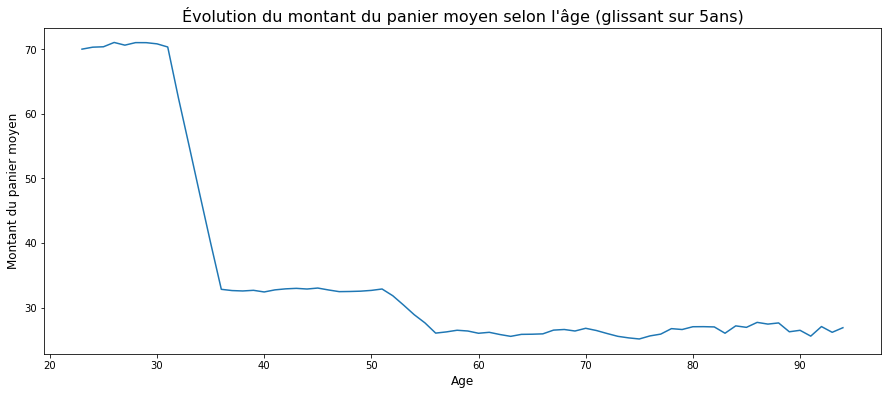

In [56]:
moy_panier = age_panier.groupby("âge").mean().reset_index()
moy_panier["moy_mob_5a"] = moy_panier["moy_panier"].rolling(5).mean()

plt.figure(figsize=(15, 6))
plt.title("Évolution du montant du panier moyen selon l'âge (glissant sur 5ans)", size=16)

plt.plot(moy_panier["âge"], moy_panier["moy_mob_5a"])

plt.ylabel("Montant du panier moyen", size = 12)
plt.xlabel("Age", size = 12)

plt.show()

Nous avons ici une relation négative beaucoup plus forte (rho = -0.7) qui se transpose assez clairement graphiquement.

En effet on osberve aisément qu'une augmentation de l'âge entraine une baisse du montant du panier moyen. Seul quelques zones de stagnation explique que rho ne soit pas encore plus élevé, mais ici le lien entre les 2 variables est évident.

### 6) Lien entre Age des clients et Catégorie des livres achetés <a class="anchor" id="section_3_6"></a>

Nous avons ici une variable quantitative (âge) et une variable qualitative (catégorie). Nous allons donc dans un premier temps observé la distribution des âges de nos clients au sein des catégories à l'aide d'une boite à moustache:

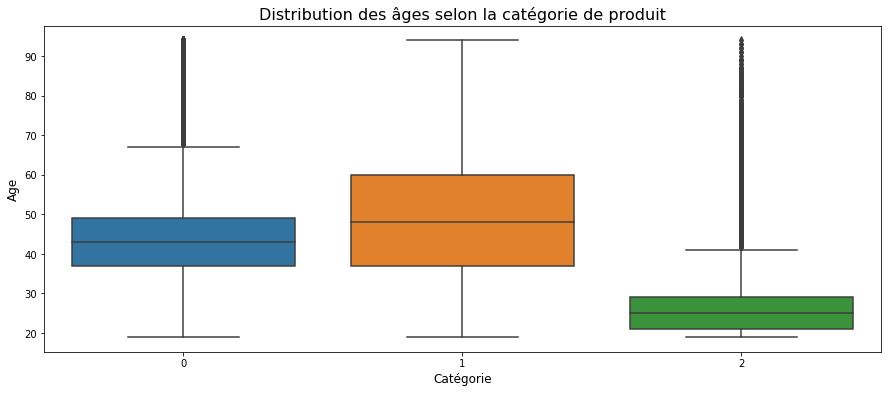

In [57]:
plt.figure(figsize=(15, 6))
plt.title("Distribution des âges selon la catégorie de produit", size=16)

sns.boxplot(y=test["âge"], x=test["catégorie"], data=test, orient="v")

plt.ylabel("Age", size = 12)
plt.xlabel("Catégorie", size = 12)

plt.show()

Visuellement, il semble bien y avoir une relation entre la catégorie et l'âge des clients qui achète cette catégorie.
Par exemple, la catégorie 2 attire principalement des clients en dessous de 30 ans, tandis que la catégorie 1 semble être plus populaire chez les 40-60 ans.

On sait que notre variable "âge" est non-paramétrique et devrions nous diriger vers un test de Kruskal-Wallis afin de tester statistiquement l'indépendance des ces variables.

Cependant, afin de varier les tests réalisés nous allons ici forcer un test **ANOVA** dont l'hypothèse nulle est que les distributions de nos groupes suivent la même loi normale.
L'hypothèse alternative est qu'il existe au moins une distribution dont la moyenne s'écarte des autres moyennes, indiquant la non-indépendance des variables et l'influence de la variable qualitative sur la variable quantitative.

Nous allons aussi forcer une autre condition à la réalisation d'une ANOVA en passant outre les résultats du test d'égalité des variances de **LEVENE**. Celui-ci teste l'hypothèse nulle que les variances de population entre les groupes sont égales.

In [58]:
#afin de les comparer on crée les 3 groupes regroupant les âges selon la catégorie
cat_0 = test["âge"].loc[test["catégorie"] == 0]
cat_1 = test["âge"].loc[test["catégorie"] == 1]
cat_2 = test["âge"].loc[test["catégorie"] == 2]

In [59]:
stats.levene(cat_0,
             cat_1,
             cat_2,
             center = "mean")

LeveneResult(statistic=24205.354599582322, pvalue=0.0)

Comme attendu p est bien inférieur à 0.05 et nous devrions donc rejeter H0 et admettre que les variances des groupes sont différentes.

Nous passons outre ce résultat et réalisons donc l'ANOVA:

In [60]:
stats.f_oneway(cat_0, cat_1, cat_2)

F_onewayResult(statistic=40411.453064066925, pvalue=0.0)

Encore une fois p est inférieur à 0.05 et devons admettre l'hypothèse alternative que la distribution d'au moins un des groupes est différente et par conséquent que **les variables "âge" et "catégorie" sont dépendantes** de manière significative.

***

Afin d'obtenir des résultats plus parlants et sans "tricher", nous allons réaliser un autre test.

Pour cela nous allons tout d'abord discrétiser la variable "âge" en tranche de 20 ans:

In [61]:
test.loc[(test["âge"] < 30), "age_group"] = "30-"
test.loc[(test["âge"] > 29) & (test["âge"] < 50), "age_group"] = "30-50"
test.loc[(test["âge"] > 49) & (test["âge"] < 70), "age_group"] = "50-70"
test.loc[(test["âge"] > 69), "age_group"] = "70+"

C:\Users\MSI\AppData\Local\Temp\ipykernel_9496\3515967264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[(test["âge"] < 30), "age_group"] = "30-"


Nos 2 variables sont maintenant qualitatives (age_group & catégorie) et nous pouvons donc effectuer un test du Chi2:

In [62]:
chi2_cramer_test(test, "age_group", "catégorie")

On teste ici l'hypothèse nulle (H0) selon laquelle les variables age_group et catégorie sont indépendantes:
p_value est inférieur à 0.05
L'hypothèse nulle est donc rejetée ---> H1: Les variables age_group et catégorie sont dépendantes de manière significative.
V = 0.24465680781670154
L'intensité de le relation entre les deux variables est moyenne .


Cela confirme le résultat obtenu grâce à l'ANOVA.

Pour mieux comprendre les sources de cette relation, réalisons une carte de chaleur:

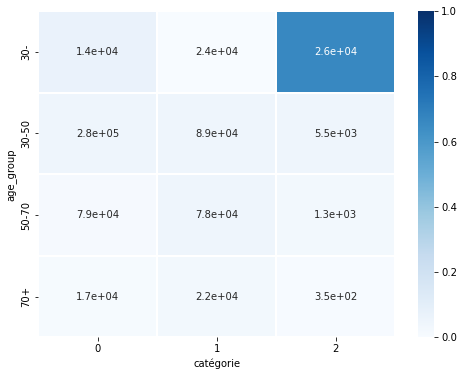

In [63]:
cont_agecat = test[["age_group","catégorie"]].pivot_table(index="age_group", columns="catégorie", aggfunc=len, margins=True)

totalx = cont_agecat.loc[:,["All"]] #ligne "All"
totaly = cont_agecat.loc[["All"],:] #colonne "All"
n = len(test) #population
indep = totalx.dot(totaly) / n # tableau (produit matriciel) représentant le cas d'indépendance (fi x nj = ni x nj / n)

measure = (cont_agecat-indep)**2/indep # différence entre nij et ni x nj pour chaque case du tableau
xi_n = measure.sum().sum() # nombre de contributions
table = measure/xi_n # normalisation des écarts grâce au total de contributions

plt.figure(figsize=(8, 6))

sns.heatmap(table.iloc[:-1,:-1], annot=cont_agecat.iloc[:-1,:-1], vmin=0, vmax=1, cmap="Blues", linewidth=2)

plt.show()

On comprend ici que c'est la consommation de produits de la catégorie 2 par les clients de 30 ans et moins qui contribue le plus à la non-indépendance des variables.

### 7) Conclusion <a class="anchor" id="section_3_7"></a>

Tous les tests effectuaient plus haut ont montré des corrélations entre les différentes variables et notamment souligné l'influence plus ou moins importante de l'âge sur le comportement de nos clients.

Retenant les corrélations les plus fortes, il faut surtout souligner l'impact de l'âge sur le montant du panier moyen. Ainsi essayer de mettre en place des actions push visant les clients "plus âgés", qui ont d'ailleurs tendances à revenir plus souvent faire des achats, a augmenté le montant de leur panier pourrait être un levier intéressant afin de générer plus de chiffre d'affaires.

Aussi la catégorie 2 est en retard en terme de chiffre d'affaire mais semble clairement destiner à la "jeunesse". Mettre en avant ces produits auprès de cette catégorie d'âge ainsi que faciliter l'accès et l'achat sur le site au moins de 18 ans, visiblement obligés de mentir sur leur âge, pourrait permettre une croissance de la catégorie.